In [1]:
import os
import sys
from importlib import reload
path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path)
        
import torch
from time import time 
import csv

import numpy as np
import scipy as sc
import pandas as pd

import gb1
import utils
import models

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 14

import seaborn as sns
sns.set_style('darkgrid')

MODEL_PATH = '/data/wongfanc/gb1-models/'

2024-09-20 23:17:35.587177: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 23:17:35.587208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 23:17:35.588299: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 23:17:35.595656: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-20 23:17:37.510387: W tensorflow/comp

160000 160000 (160000, 4, 21)


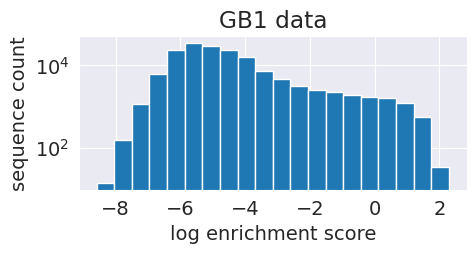

In [2]:
# load and plot GB1 sequences, binding affinities, and estimated variances
df = pd.read_csv('../data/gb1-with-variance.csv')
seq_n = list(df['Variants'].str.lower())
y_n = df['log_fitness'].to_numpy()
var_n = df['estimated_variance'].to_numpy()
ohe_nxla = np.stack([utils.str2onehot(seq, gb1.AA).flatten() for seq in seq_n])
ohe_nxlxa = np.stack([utils.str2onehot(seq, gb1.AA) for seq in seq_n])
print(len(seq_n), y_n.size, ohe_nxlxa.shape)

plt.figure(figsize=(5, 2))
plt.hist(y_n, bins=20, log=True);
plt.xlabel('log enrichment score');
plt.ylabel('sequence count');
plt.title('GB1 data');

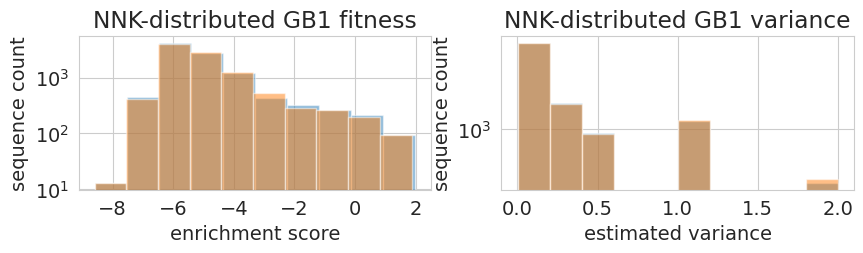

In [49]:
# generate NNK training and test data
reload(gb1)
n_train = 10000

_, nnkohe_nxla, nnkseq_n = gb1.sample_ohe_from_nuc_distribution(gb1.PNUC_NNK_LXA, 2 * n_train)
ynnk_nx2 = np.array([gb1.SEQ2YVAR[seq] for seq in nnkseq_n])

trainohe_nxla, testohe_nxla = nnkohe_nxla[: n_train], nnkohe_nxla[n_train :]
ytrain_nx2, ytest_nx2 = ynnk_nx2[: n_train], ynnk_nx2[n_train :]

plt.figure(figsize=(10, 2))
plt.subplot(121)
plt.hist(ytrain_nx2[:, 0], alpha=0.5, log=True);
plt.hist(ytest_nx2[:, 0], alpha=0.5, log=True);
plt.xlabel('enrichment score');
plt.ylabel('sequence count');
plt.title('NNK-distributed GB1 fitness');

plt.subplot(122)
plt.hist(ytrain_nx2[:, 1], alpha=0.5, log=True);
plt.hist(ytest_nx2[:, 1], alpha=0.5, log=True);
plt.xlabel('estimated variance');
plt.ylabel('sequence count');
plt.title('NNK-distributed GB1 variance');


Sequences are already one-hot encoded.
9000 training data points, 1000 validation data points.


100%|███████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:02<00:00, 334.60it/s]


Epoch 0. Train loss: 188.30. Val loss: 281.54. 2 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:02<00:00, 332.83it/s]


Epoch 1. Train loss: 86.41. Val loss: 105.69. 2 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:02<00:00, 308.72it/s]


Epoch 2. Train loss: 73.60. Val loss: 73.66. 3 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:02<00:00, 332.09it/s]


Epoch 3. Train loss: 66.17. Val loss: 66.89. 2 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:02<00:00, 330.47it/s]


Epoch 4. Train loss: 60.33. Val loss: 59.99. 2 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:02<00:00, 329.46it/s]


Epoch 5. Train loss: 54.52. Val loss: 58.64. 3 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:02<00:00, 329.99it/s]


Epoch 6. Train loss: 49.43. Val loss: 52.25. 3 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:02<00:00, 333.26it/s]


Epoch 7. Train loss: 44.53. Val loss: 51.92. 2 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:02<00:00, 328.45it/s]


Epoch 8. Train loss: 40.64. Val loss: 46.12. 3 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:02<00:00, 335.06it/s]

Epoch 9. Train loss: 35.79. Val loss: 43.07. 2 sec.


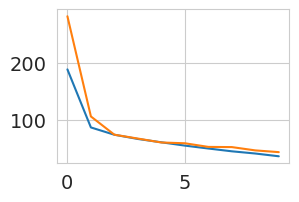

In [50]:
# train NN model
reload(models)

n_epoch = 10
n_hidden = 10
n_model = 3
lr = 1e-3
batch_size = 10
n_data_workers = 1
device = torch.device(0)

model = models.FeedForward(
    seq_len=4,
    alphabet=gb1.AA,
    n_hidden=n_hidden,
    n_model=n_model,
    device=device
)
loss_tx2 = model.fit(
    trainohe_nxla,
    ytrain_nx2,
    lr=lr,
    batch_size=batch_size,
    n_epoch=n_epoch,
    n_data_workers=n_data_workers
)
plt.figure(figsize=(3, 2))
plt.plot(loss_tx2[:, 0])
plt.plot(loss_tx2[:, 1])

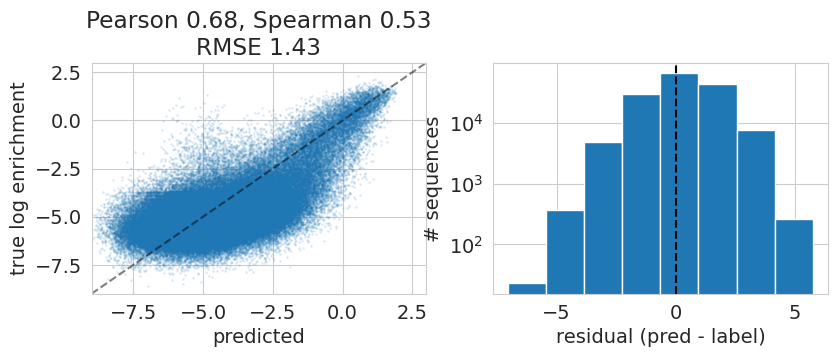

In [52]:
# test on all other sequences
testseq_n = [s for s in seq_n if s not in nnkseq_n[: n_train]]
ytest_n = np.array([gb1.SEQ2YVAR[s][0] for s in testseq_n])
pred_n = model.predict(testseq_n)
xy_lim = [-9, 3]

plt.figure(figsize=(9.5, 3))
plt.subplot(121)
plt.scatter(pred_n, ytest_n, alpha=0.1, s=1);
plt.plot(xy_lim, xy_lim, '--k', alpha=0.5)
r, p = sc.stats.pearsonr(ytest_n, pred_n)
rho, p = sc.stats.spearmanr(ytest_n, pred_n)
rmse = np.sqrt(np.mean(np.square(ytest_n - pred_n)))

plt.ylim(xy_lim);
plt.xlim(xy_lim)
plt.title('Pearson {:.2f}, Spearman {:.2f}\nRMSE {:.2f}'.format(r, rho, rmse));
plt.ylabel('true log enrichment'); plt.xlabel('predicted');

plt.subplot(122)
plt.hist(pred_n - ytest_n, bins=8, log=True);
plt.ylabel('# sequences')
plt.axvline(0, linestyle='--', color='k')
plt.xlabel('residual (pred - label)');

(10000, 4, 21)


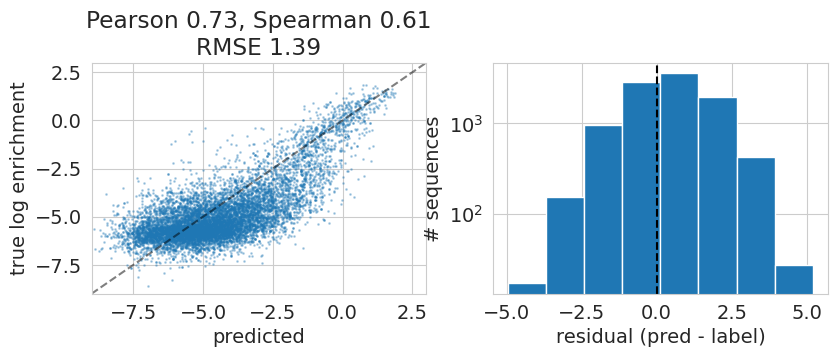

In [51]:
print(testohe_nxla.shape)
pred_n = model.predict(testohe_nxla)
xy_lim = [-9, 3]

plt.figure(figsize=(9.5, 3))
plt.subplot(121)
plt.scatter(pred_n, ytest_nx2[:, 0], alpha=0.3, s=1);
plt.plot(xy_lim, xy_lim, '--k', alpha=0.5)
r, p = sc.stats.pearsonr(ytest_nx2[:, 0], pred_n)
rho, p = sc.stats.spearmanr(ytest_nx2[:, 0], pred_n)
rmse = np.sqrt(np.mean(np.square(ytest_nx2[:, 0] - pred_n)))

plt.ylim(xy_lim);
plt.xlim(xy_lim)
plt.title('Pearson {:.2f}, Spearman {:.2f}\nRMSE {:.2f}'.format(r, rho, rmse));
plt.ylabel('true log enrichment'); plt.xlabel('predicted');

plt.subplot(122)
plt.hist(pred_n - ytest_nx2[:, 0], bins=8, log=True);
plt.ylabel('# sequences')
plt.axvline(0, linestyle='--', color='k')
plt.xlabel('residual (pred - label)');

In [4]:
# load model
reload(gb1)

n_hidden = 10
n_model = 3
device = torch.device(0)

model = models.FeedForward(
    seq_len=4,
    alphabet=gb1.AA,
    n_hidden=n_hidden,
    n_model=n_model,
    device=device
)
model.load('/data/wongfanc/gb1-models/gb1-h10-10k-051324')

In [93]:
# get design distributions
# REMINDER: set save_fname_no_ftype appropriately!
reload(gb1)

overwrite_old_library = True
n_train = 10000
temperatures = np.array([0.5850]) # np.arange(0.2, 0.701, 0.005)
lr = 0.1
n_sample = 1000
n_iter = 4000
pareto_tx3 = np.empty([temperatures.size, 3])

for t, temp in enumerate(temperatures):
    print('Temperature = {:.4f}'.format(temp))
    save_fname_no_ftype = 'gb1-h{}-{}k-t{:.4f}-051324'.format(n_hidden, int(n_train / 1000), temp)
    # save_fname_no_ftype = None
    
    t0 = time()
    theta_lxa, df = gb1.solve_max_entropy_library(
        model,
        temperature=temp,
        lr=lr,
        n_sample=n_sample,
        n_iter=n_iter,
        save_fname_no_ftype=save_fname_no_ftype,
        overwrite_old_library=overwrite_old_library,
    )
    print('Done solving for library ({} s)'.format(int(time() - t0)))
    
    paa_lxa = gb1.get_aa_probs_from_nuc_probs(gb1.normalize_theta(theta_lxa))
    pdesign_n = np.exp(gb1.get_nostop_loglikelihood(gb1.ALL_NOSTOP_AA_OHE, paa_lxa))
    truemean = np.sum([p * gb1.SEQ2YVAR[seq][0] for p, seq in zip(pdesign_n, gb1.ALL_NOSTOP_AA_SEQS)])
    pareto_tx3[t] = df.loc[n_iter]['mean_prediction'], df.loc[n_iter]['epd'], truemean
    print('True mean label: {:.2f} ({} s)'.format(truemean, int(time() - t0)))
    print()

Temperature = 0.5850
Iter: 1. Objective: 2.70. Mean prediction: -4.91. Mean no-stop prediction: -4.99. Entropy: 13.00. AA EPD: 3.42
Iter: 500. Objective: 7.62. Mean prediction: -0.01. Mean no-stop prediction: -0.00. Entropy: 13.06. AA EPD: 3.19
Iter: 1000. Objective: 7.74. Mean prediction: 0.28. Mean no-stop prediction: 0.31. Entropy: 12.75. AA EPD: 2.99
Iter: 1500. Objective: 7.70. Mean prediction: 0.40. Mean no-stop prediction: 0.49. Entropy: 12.46. AA EPD: 2.80
Iter: 2000. Objective: 7.77. Mean prediction: 0.52. Mean no-stop prediction: 0.54. Entropy: 12.39. AA EPD: 2.80
Iter: 2500. Objective: 7.86. Mean prediction: 0.59. Mean no-stop prediction: 0.45. Entropy: 12.42. AA EPD: 2.79
Iter: 3000. Objective: 7.77. Mean prediction: 0.49. Mean no-stop prediction: 0.48. Entropy: 12.45. AA EPD: 2.82
Iter: 3500. Objective: 7.78. Mean prediction: 0.55. Mean no-stop prediction: 0.53. Entropy: 12.35. AA EPD: 2.79
Iter: 4000. Objective: 7.82. Mean prediction: 0.56. Mean no-stop prediction: 0.58. 

In [56]:
# 09/18/24: outdated, need to save to /data/wongfanc/gb1-models
fname = 'gb1-h{}-{}k-051424'.format(n_hidden, int(n_train / 1000))
model.save(fname)
train_idx = np.array([seq_n.index(seq) for seq in nnkseq_n])
np.savez('../gb1-models/{}-train-idx.npz'.format(fname), train_idx=train_idx)

Saved models to gb1-h10-10k-051424.


In [94]:
# compute mean prediction and true mean for each design distribution
temperatures = np.arange(0.2, 0.701, 0.005)
pareto_tx2 = np.empty([temperatures.size, 2])
predall_n = model.predict(gb1.ALL_NOSTOP_AA_SEQS)
for t, temp in enumerate(temperatures):
    theta_lxa = np.load(MODEL_PATH + 'gb1-h10-10k-t{:.4f}-051324.npz'.format(temp))['theta_lxa']
    paa_lxa = gb1.get_aa_probs_from_nuc_probs(gb1.normalize_theta(theta_lxa))
    pdesign_n = np.exp(gb1.get_nostop_loglikelihood(gb1.ALL_NOSTOP_AA_OHE, paa_lxa))
    truemean = np.sum([p * gb1.SEQ2YVAR[seq][0] for p, seq in zip(pdesign_n, gb1.ALL_NOSTOP_AA_SEQS)])
    predmean = np.sum([p * pred for p, pred in zip(pdesign_n, predall_n)])
    pareto_tx2[t] = truemean, predmean
    print('{:.4f}. mean label: {:.2f}, mean prediction: {:.2f}'.format(
        temp, truemean, predmean
    ))

0.2000. mean label: 0.92, mean prediction: 1.29
0.2050. mean label: 1.12, mean prediction: 1.44
0.2100. mean label: 0.92, mean prediction: 1.29
0.2150. mean label: 1.10, mean prediction: 1.43
0.2200. mean label: 1.09, mean prediction: 1.41
0.2250. mean label: 0.90, mean prediction: 1.27
0.2300. mean label: 0.87, mean prediction: 1.26
0.2350. mean label: 0.86, mean prediction: 1.26
0.2400. mean label: 1.05, mean prediction: 1.39
0.2450. mean label: 1.02, mean prediction: 1.37
0.2500. mean label: 0.84, mean prediction: 1.23
0.2550. mean label: 1.01, mean prediction: 1.35
0.2600. mean label: 1.01, mean prediction: 1.36
0.2650. mean label: 0.82, mean prediction: 1.20
0.2700. mean label: 1.00, mean prediction: 1.34
0.2750. mean label: 0.78, mean prediction: 1.17
0.2800. mean label: 0.94, mean prediction: 1.31
0.2850. mean label: 0.78, mean prediction: 1.16
0.2900. mean label: 0.90, mean prediction: 1.28
0.2950. mean label: 0.88, mean prediction: 1.27
0.3000. mean label: 0.75, mean predictio

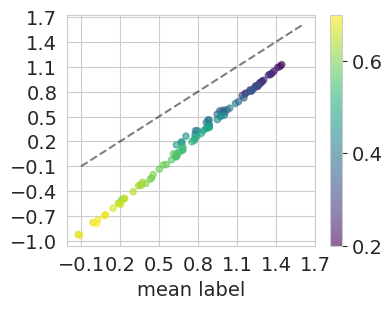

In [106]:
# plot mean label vs. mean prediction for all design distributions
sns.set_style('whitegrid')
plt.figure(figsize=(4, 3))
plt.scatter(pareto_tx2[:, 1], pareto_tx2[:, 0], s=20, alpha=0.6, c=temperatures, cmap='viridis')
plt.plot([-0.1, 1.6], [-0.1, 1.6], '--k', alpha=0.5)
plt.colorbar();
plt.xlabel('mean prediction');
plt.xlabel('mean label');
plt.xticks(np.arange(-0.1, 1.8, 0.3));
plt.yticks(np.arange(-1, 1.7, 0.3));

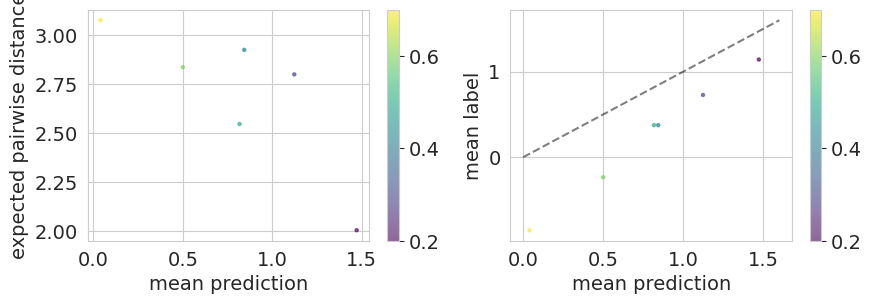

In [55]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 3))
temperatures = np.arange(0.2, 0.701, 0.1)

plt.subplot(121)
plt.scatter(pareto_tx3[:, 0], pareto_tx3[:, 1], s=5, alpha=0.6, c=temperatures, cmap='viridis')
plt.colorbar()
plt.xlabel('mean prediction');
plt.ylabel('expected pairwise distance');
# plt.xlim([0, 1.7]);
# plt.ylim([0, 3]);

plt.subplot(122)
plt.scatter(pareto_tx3[:, 0], pareto_tx3[:, 2], s=5, alpha=0.6, c=temperatures, cmap='viridis')
plt.plot([0, 1.6], [0, 1.6], '--k', alpha=0.5)
# plt.ylim([0, 1.6]);
# plt.xlim([0, 1.6]);
plt.colorbar()
plt.xlabel('mean prediction');
plt.ylabel('mean label');

In [5]:
# compute mean prediction and true mean for each design distribution
# from samples
# based on samples (sanity checking above figures which used closed-form computations)

temperatures = np.arange(0.2, 0.701, 0.005)
temp2theta = {
    round(temp, 4): np.load(MODEL_PATH + 'gb1-h10-10k-t{:.4f}-051324.npz'.format(temp))['theta_lxa']
    for temp in temperatures
}
temp2mean = gb1.get_true_mean_label_from_theta(temp2theta)

In [7]:
save_path = '/data/wongfanc/gb1-results/'
design_samples_fname_prefix = 'gb1-h10-10k-051324-samples'
pareto_tx2 = np.empty([temperatures.size, 2])

for t, temp in enumerate(temperatures):
    temp = round(temp, 4)
    theta_lxa = np.load(MODEL_PATH + 'gb1-h10-10k-t{:.4f}-051324.npz'.format(temp))['theta_lxa']
    
    design_samples_fname = os.path.join(save_path, '{}-t{:.4f}-0.npz'.format(design_samples_fname_prefix, temp))
    d = np.load(design_samples_fname)
    designohe_nxlxa = d['designohe_nxlxa']
    preddesign_n = model.predict(designohe_nxlxa)
    imputed_mean = np.mean(preddesign_n)
    
    pareto_tx2[t] = temp2mean[temp], imputed_mean
    print('{:.4f}. mean label: {:.2f}, mean prediction: {:.2f}'.format(
        temp, temp2mean[temp], imputed_mean
    ))

0.2000. mean label: 0.92, mean prediction: 1.29
0.2050. mean label: 1.12, mean prediction: 1.44
0.2100. mean label: 0.92, mean prediction: 1.29
0.2150. mean label: 1.10, mean prediction: 1.43
0.2200. mean label: 1.09, mean prediction: 1.41
0.2250. mean label: 0.90, mean prediction: 1.27
0.2300. mean label: 0.87, mean prediction: 1.26
0.2350. mean label: 0.86, mean prediction: 1.26
0.2400. mean label: 1.05, mean prediction: 1.39
0.2450. mean label: 1.02, mean prediction: 1.37
0.2500. mean label: 0.84, mean prediction: 1.23
0.2550. mean label: 1.01, mean prediction: 1.35
0.2600. mean label: 1.01, mean prediction: 1.36
0.2650. mean label: 0.82, mean prediction: 1.20
0.2700. mean label: 1.00, mean prediction: 0.87
0.2750. mean label: 0.78, mean prediction: 1.17
0.2800. mean label: 0.94, mean prediction: 1.31
0.2850. mean label: 0.78, mean prediction: 1.16
0.2900. mean label: 0.90, mean prediction: 1.28
0.2950. mean label: 0.88, mean prediction: 1.27
0.3000. mean label: 0.75, mean predictio

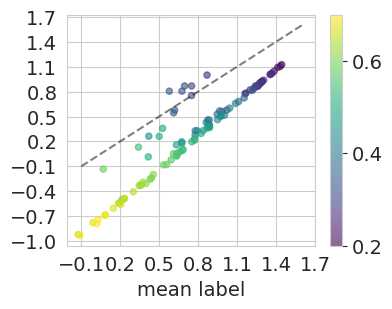

In [8]:
# plot mean label vs. mean prediction for all design distributions
sns.set_style('whitegrid')
plt.figure(figsize=(4, 3))
plt.scatter(pareto_tx2[:, 1], pareto_tx2[:, 0], s=20, alpha=0.6, c=temperatures, cmap='viridis')
plt.plot([-0.1, 1.6], [-0.1, 1.6], '--k', alpha=0.5)
plt.colorbar();
plt.xlabel('mean prediction');
plt.xlabel('mean label');
plt.xticks(np.arange(-0.1, 1.8, 0.3));
plt.yticks(np.arange(-1, 1.7, 0.3));

# imputation selection experiments

In [2]:
# load 10k-trained model
reload(gb1)

n_hidden = 10
n_model = 3
device = torch.device(0)

model = models.FeedForward(
    seq_len=4,
    alphabet=gb1.AA,
    n_hidden=n_hidden,
    n_model=n_model,
    device=device
)
model.load('/data/wongfanc/gb1-models/gb1-h10-10k-051324')

In [3]:
# load design distributions from imputation
temperatures = np.arange(0.2, 0.701, 0.005)

# imputation distributions
imptemp2theta = {
    round(temp, 4): np.load(MODEL_PATH + 'gb1-h10-10k-t{:.4f}-051324.npz'.format(temp))['theta_lxa']
    for temp in temperatures
}
imptemp2mean = gb1.get_true_mean_label_from_theta(imptemp2theta)
imptemp2exceed = gb1.get_true_mean_label_from_theta(imptemp2theta, threshold=1.1)

In [6]:
reload(models)
reload(gb1)

# TOGGLE FOR EXCEEDANCE:
run_exceedance = True
threshold = 1.1
target_values = np.arange(0.0, 1.01, 0.02) # np.arange(0.0, 1.51, 0.05)

# no need to toggle for exceedance
n_trial = 10
n_design = 1000000
results_csv_fname = 'gb1-imp-{}092024.csv'.format(
    'exceed{}-'.format(threshold) if run_exceedance else '',
)
save_design_samples = False
load_design_samples = True

design_samples_fname_prefix = 'gb1-h10-10k-051324-samples'

df = gb1.run_imputation_selection_experiments(
    model,
    imptemp2theta,
    target_values,
    n_trial,
    exceedance_threshold=threshold if run_exceedance else None,
    n_design=n_design,
    results_csv_fname=results_csv_fname,
    design_samples_fname_prefix=design_samples_fname_prefix,
    save_design_samples=save_design_samples,
    load_design_samples=load_design_samples
)

Selection quantity is probability of exceeding 1.1.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2000-0.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2000-1.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2000-2.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2000-3.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2000-4.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2000-5.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2000-6.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2000-7.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2000-8

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2350-0.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2350-1.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2350-2.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2350-3.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2350-4.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2350-5.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2350-6.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2350-7.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2350-8.npz.
Loaded 1000000 design sequences from /data/won

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2700-0.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2700-1.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2700-2.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2700-3.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2700-4.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2700-5.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2700-6.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2700-7.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.2700-8.npz.
Loaded 1000000 design sequences from /data/won

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3050-0.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3050-1.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3050-2.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3050-3.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3050-4.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3050-5.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3050-6.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3050-7.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3050-8.npz.
Loaded 1000000 design sequences from /data/won

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3400-0.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3400-1.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3400-2.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3400-3.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3400-4.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3400-5.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3400-6.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3400-7.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3400-8.npz.
Loaded 1000000 design sequences from /data/won

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3750-0.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3750-1.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3750-2.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3750-3.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3750-4.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3750-5.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3750-6.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3750-7.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.3750-8.npz.
Loaded 1000000 design sequences from /data/won

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4100-0.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4100-1.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4100-2.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4100-3.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4100-4.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4100-5.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4100-6.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4100-7.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4100-8.npz.
Loaded 1000000 design sequences from /data/won

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4450-0.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4450-1.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4450-2.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4450-3.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4450-4.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4450-5.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4450-6.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4450-7.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4450-8.npz.
Loaded 1000000 design sequences from /data/won

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4800-0.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4800-1.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4800-2.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4800-3.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4800-4.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4800-5.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4800-6.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4800-7.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.4800-8.npz.
Loaded 1000000 design sequences from /data/won

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5150-0.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5150-1.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5150-2.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5150-3.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5150-4.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5150-5.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5150-6.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5150-7.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5150-8.npz.
Loaded 1000000 design sequences from /data/won

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5500-0.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5500-1.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5500-2.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5500-3.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5500-4.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5500-5.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5500-6.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5500-7.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5500-8.npz.
Loaded 1000000 design sequences from /data/won

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5850-0.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5850-1.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5850-2.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5850-3.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5850-4.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5850-5.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5850-6.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5850-7.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.5850-8.npz.
Loaded 1000000 design sequences from /data/won

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6200-0.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6200-1.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6200-2.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6200-3.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6200-4.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6200-5.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6200-6.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6200-7.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6200-8.npz.
Loaded 1000000 design sequences from /data/won

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6550-0.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6550-1.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6550-2.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6550-3.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6550-4.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6550-5.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6550-6.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6550-7.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6550-8.npz.
Loaded 1000000 design sequences from /data/won

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6900-0.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6900-1.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6900-2.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6900-3.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6900-4.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6900-5.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6900-6.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6900-7.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-10k-051324-samples-t0.6900-8.npz.
Loaded 1000000 design sequences from /data/won